# Análise de Delivery

In [1]:
# Importação dos pacotes necessários

import pandas as pd
pd.set_option('display.max_columns', None)
import duckdb
import numpy as np

In [2]:
# Importação dos dados

stores = pd.read_csv("stores.csv", encoding = 'ISO-8859-1')
channels = pd.read_csv("channels.csv")
deliveries = pd.read_csv("deliveries.csv")
hubs = pd.read_csv("hubs.csv", encoding = 'ISO-8859-1')
drivers = pd.read_csv("drivers.csv")
payments = pd.read_csv("payments.csv")
orders = pd.read_csv("orders.csv")

#### Relacionamentos dos Dados

Note que nem todas as tabelas se relacionam entre si, mas o ponto focal é na tabela de pedidos, onde a maior parte das relações ocorre.

![Relacionamentos dos Dados](database_relations.png )

In [3]:
# Criando a conexão com o duckdb e criando os registros dos dados na memória para trabalho

con = duckdb.connect(database=':memory:', read_only=False)

con.register('orders', orders)
con.register('stores', stores)
con.register('channels', channels)
con.register('drivers', drivers)
con.register('deliveries', deliveries)
con.register('hubs', hubs)
con.register('payments', payments)

## Perguntas Exploratórias

### Operações e Logística

- Pergunta: Qual é a média de distância percorrida pelos entregadores em cada tipo de veículo?

In [4]:
query = """
SELECT
    drivers.driver_modal,
    AVG(delivery_distance_meters)
FROM
    deliveries
JOIN
    drivers
        ON
            deliveries.driver_id = drivers.driver_id
GROUP BY
    drivers.driver_modal
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado

,0,1
0,MOTOBOY,3447.114412
1,BIKER,1109.194339


- Pergunta: Qual é o hub com o maior número de entregas realizadas durante o mês de abril de 2021?

In [5]:
query = """
SELECT
    hubs.hub_name,
    hubs.hub_state,
    COUNT(orders.order_id) AS contagem     
FROM
        hubs
JOIN
    stores    
        ON
            stores.hub_id = hubs.hub_id
JOIN
    orders
        ON
            orders.store_id = stores.store_id
GROUP BY
    hubs.hub_name,
    hubs.hub_state
ORDER BY
    contagem DESC

        
    
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(5) 

,0,1,2
0,GOLDEN SHOPPING,RJ,44868
1,SUBWAY SHOPPING,SP,23155
2,PAGODE SHOPPING,SP,22771
3,HIP HOP SHOPPING,RJ,21230
4,GREEN SHOPPING,RS,21139


- Pergunta: Qual é o canal de venda (marketplace) com o maior volume de pedidos processados?

In [6]:
query = """
SELECT
    channels.channel_name,
    COUNT(orders.order_id) AS qtdade
FROM
    channels
JOIN 
    orders
        ON
            orders.channel_id = channels.channel_id
GROUP BY
    channels.channel_name
ORDER BY
    qtdade DESC



"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(15) 

,0,1
0,FOOD PLACE,288723
1,EATS PLACE,15109
2,LONDON PLACE,12474
3,CHOCO PLACE,10367
4,OTHER PLACE,9204
5,VELOCITY PLACE,9103
6,LISBON PLACE,8589
7,WHATS PLACE,4753
8,SHOPP PLACE,3222
9,BRAZIL PLACE,1509


### Finanças

- Pergunta: Qual é o método de pagamento mais utilizado pelos clientes para fazer compras na plataforma?

In [7]:
query ="""
SELECT
    payment_method,
    COUNT(order_id) as contagem
FROM 
    orders
INNER JOIN
    payments
        ON
            payments.payment_order_id = orders.order_id
GROUP BY
    payment_method
ORDER BY
    contagem DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(5) 

,0,1
0,ONLINE,312377
1,VOUCHER,48570
2,DEBIT,12347
3,MEAL_BENEFIT,6687
4,STORE_DIRECT_PAYMENT,6574


- Pergunta: Qual é o total de receita gerada pela taxa de entrega durante o período de janeiro a abril de 2021?

In [15]:
query ="""
SELECT
    payment_method,
    SUM(payment_fee) AS soma
FROM 
    orders
INNER JOIN
    payments
        ON
            payments.payment_order_id = orders.order_id
WHERE 
    payment_status = 'PAID'
GROUP BY
    payment_method

ORDER BY
    soma DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(5) 

,0,1
0,ONLINE,677711.93
1,STORE_DIRECT_PAYMENT,35901.65
2,DEBIT,12255.56
3,CREDIT,7532.96
4,VOUCHER_STORE,4813.01


- Pergunta: Qual foi o total de vendas processadas em cada mês do primeiro trimestre de 2021?



In [9]:
orders.head(2)

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.0,NaN,0,1,1,1,2021,1/1/2021 12:01:36 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.0,NaN,0,4,1,1,2021,1/1/2021 12:04:26 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
query ="""
SELECT
    order_created_month,
    SUM(order_amount) AS soma
FROM 
    orders
WHERE 
    order_status = 'FINISHED' AND
    order_created_month IN ('1', '2', '3')
GROUP BY
    order_created_month
ORDER BY
    order_created_month

"""

resultado = round(pd.DataFrame(con.execute(query).fetchall()),2)
resultado.head(5) 

,0,1
0,1,6483518.89
1,2,6309575.49
2,3,11648479.74


### Vendas e Marketing:

- Pergunta: Qual é o segmento de loja (store_segment) que possui o maior volume de vendas durante o período analisado?

In [11]:
query ="""
SELECT
    store_segment,
    COUNT(order_id) AS contagem
FROM 
    orders
INNER JOIN
    stores
        ON
            stores.store_id = orders.store_id

GROUP BY
    store_segment

ORDER BY
    contagem DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(5) 

,0,1
0,FOOD,321775
1,GOOD,47224


- Pergunta: Qual é o canal de venda (channel_name) que gera o maior valor médio de pedido (order_amount)?

In [12]:
query ="""
SELECT
    channel_name,
    AVG(order_amount) AS media
FROM 
    orders
INNER JOIN
    channels
        ON
            channels.channel_id = orders.channel_id

GROUP BY
    channel_name

ORDER BY
    media DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall())
resultado.head(5) 

,0,1
0,ON PLACE,471.930000
1,LISBON PLACE,433.137954
2,AHORA PLACE,385.240000
3,PORTO PLACE,349.800000
4,CENTER PLACE,285.055444


- Pergunta: Qual é o momento do dia em que mais pedidos são realizados na plataforma?



In [13]:
query ="""
SELECT
    order_created_hour,
    COUNT(order_id) AS contagem 
FROM 
    orders


GROUP BY
    order_created_hour

ORDER BY
    order_created_hour
"""

resultado = pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['hora', 'total de pedidos'])
resultado['log'] = round(np.log2(resultado['total de pedidos']),2)



resultado

,hora,total de pedidos,log
0,0,26760,14.71
1,1,4338,12.08
2,2,1121,10.13
3,3,785,9.62
4,4,296,8.21
5,5,488,8.93
6,6,293,8.19
7,7,252,7.98
8,8,158,7.30
9,9,151,7.24


In [14]:
# Define o tamanho da figura
plt.figure(figsize=(20, 6))  # Ajuste os valores conforme necessário

# Plota o gráfico de barras
resultado.plot.bar(x='hora', y='total de pedidos')

# Remover a caixa externa do gráfico
plt.box(False)




# Rotaciona os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()

NameError: name 'plt' is not defined

- Pergunta: Quais são os 10% dos lojistas que mais contribuem para a receita total da plataforma, considerando o período analisado?

In [ ]:
query ="""
WITH 

venda_por_loja AS (
    SELECT
        store_id,
        SUM(order_amount) AS venda_total
    FROM
        orders
    WHERE
        order_amount < 500
    GROUP BY
        store_id
),

ranking_das_lojas AS (
    SELECT
        store_id,
        venda_total,
        PERCENT_RANK() OVER (ORDER BY venda_total DESC) AS contribuicao
    FROM
        venda_por_loja
)

SELECT
    *
FROM
    ranking_das_lojas
WHERE
    contribuicao <= 0.1;


"""

resultado = pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['store_id', 'total de pedidos','cont'])
resultado

,store_id,total de pedidos,cont
0,676,1638501.27,0.000000
1,707,1258615.54,0.001065
2,274,1035871.97,0.002130
3,149,1025614.40,0.003195
4,658,1015308.81,0.004260
...,...,...,...
89,912,75403.03,0.094782
90,3097,74163.61,0.095847
91,1984,73475.51,0.096912
92,2541,69442.71,0.097977


- Pergunta: Quais são os 10% dos hubs que mais contribuem para a receita total da plataforma, considerando o período analisado?

In [ ]:
query ="""
WITH 

venda_por_hub AS (
    SELECT
        hubs.hub_id,
        SUM(order_amount) AS venda_total
    FROM
        orders
    INNER JOIN
        stores
            ON
                stores.store_id = orders.store_id
    INNER JOIN
        hubs
            ON
                hubs.hub_id = stores.hub_id
    WHERE
        orders.order_amount < 500
    GROUP BY
        hubs.hub_id
),

ranking_das_lojas AS (
    SELECT
        hub_id,
        venda_total,
        PERCENT_RANK() OVER (ORDER BY venda_total DESC) AS contribuicao
    FROM
        venda_por_hub
)

SELECT
    *
FROM
    ranking_das_lojas
WHERE
    contribuicao <= 0.1;


"""

resultado = pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['store_id', 'total de pedidos','cont'])
resultado

,store_id,total de pedidos,cont
0,8,3648207.91,0.000000
1,31,2465190.40,0.032258
2,29,2333036.24,0.064516
3,33,2254115.35,0.096774


## Perguntas Desafio

- Numa ação de marketing, para atrair mais entregadores, vamos dar uma bonificação para os 20 entregadores que possuem maior distância percorrida ao todo. A bonificação vai variar de acordo com o tipo de profissional que ele é e o modelo que ele usa para se locomover (moto, bike, etc). Levante essas informações.

In [ ]:
query = """
SELECT
    driver_modal,
    COUNT(*) AS total_entregadores
FROM
    drivers
GROUP BY
    driver_modal
"""
resultado = pd.DataFrame(con.execute(query).fetchall())
resultado ## 67% dos entregadores são Motoboys, os outros 33% entregam usando bike


,0,1
0,MOTOBOY,3222
1,BIKER,1602


In [16]:
query = """
WITH dist_por_driverID AS (
    SELECT
        deliveries.driver_id,
        drivers.driver_modal,
        SUM(deliveries.delivery_distance_meters) as dist_total,
        ROW_NUMBER() OVER (PARTITION BY drivers.driver_modal ORDER BY SUM(deliveries.delivery_distance_meters) DESC) AS rank
    FROM
        deliveries
    INNER JOIN
        drivers
            ON
                deliveries.driver_id = drivers.driver_id
    WHERE
        deliveries.delivery_distance_meters < 24000
    GROUP BY
        deliveries.driver_id,
        drivers.driver_modal
)
SELECT
    driver_id,
    driver_modal,
    dist_total
FROM
    dist_por_driverID
WHERE
    rank <= 13;
"""

resultado = pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['driver_id', 'driver_modal', 'dist_total'])

resultado
# Quer uma divisão meio a meio? Ou proporcional? 

,driver_id,driver_modal,dist_total
0,3780.0,BIKER,867126.0
1,794.0,BIKER,841202.0
2,12724.0,BIKER,733939.0
3,7638.0,BIKER,719445.0
4,18487.0,BIKER,623923.0
5,7773.0,BIKER,621958.0
6,12079.0,BIKER,621807.0
7,9996.0,BIKER,614831.0
8,8771.0,BIKER,608039.0
9,1203.0,BIKER,606353.0


- Além disso, o time de Pricing precisa ajustar os valores pagos aos entregadores. Para isso, eles precisam da distribuição da distância média percorrida pelos motoqueiros separada por estado, já que cada região terá seu preço.

In [ ]:
query = """
SELECT
    hubs.hub_state,
    AVG(deliveries.delivery_distance_meters) as dist_media
FROM 
    hubs
INNER JOIN
    stores
        ON
            hubs.hub_id = stores.hub_id
INNER JOIN
    orders
        ON 
            orders.store_id = stores.store_id
INNER JOIN
    deliveries
        ON
            deliveries.delivery_order_id = orders.order_id
INNER JOIN
    drivers
        ON
            drivers.driver_id = deliveries.driver_id
WHERE
    deliveries.delivery_status = 'DELIVERED' AND
    drivers.driver_modal = 'MOTOBOY' AND
    deliveries.delivery_distance_meters < 24000
GROUP BY
    hubs.hub_state
ORDER BY
    dist_media DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['driver_id', 'dist_media'])
resultado

,driver_id,dist_media
0,RS,3519.639159
1,SP,3388.256735
2,PR,3150.791876
3,RJ,2964.944732


- Por fim, o CFO precisa de alguns indicadores de receita para apresentar para a diretoria executiva. Dentre esses indicadores, vocês precisarão levantar (1) a receita média e total separada por tipo (Food x Good), (2) A receita média e total por estado. Ou seja, são 4 tabelas ao todo.

In [ ]:
query = """
SELECT
    stores.store_segment,
    SUM(orders.order_amount) as faturamento,
    AVG(orders.order_amount) as media
FROM 
    orders
INNER JOIN
    stores
        ON
            orders.store_id = stores.store_id
WHERE
    orders.order_status = 'FINISHED' 
GROUP BY
    stores.store_segment
"""

resultado = round(pd.DataFrame(con.execute(query).fetchall(),
                               columns=['tipo','faturamento','media']),2)
resultado

,tipo,faturamento,media
0,FOOD,26235435.78,84.41
1,GOOD,9057794.50,219.82


In [ ]:
query = """
SELECT
    hubs.hub_state,
    SUM(orders.order_amount) as faturamento,
    AVG(orders.order_amount) as media
FROM 
    hubs
INNER JOIN
    stores
        ON
            hubs.hub_id = stores.hub_id
INNER JOIN
    orders
        ON 
            orders.store_id = stores.store_id
INNER JOIN
    deliveries
        ON
            deliveries.delivery_order_id = orders.order_id
INNER JOIN
    drivers
        ON
            drivers.driver_id = deliveries.driver_id
WHERE
    deliveries.delivery_status = 'DELIVERED' AND
    orders.order_amount < 500
GROUP BY
    hubs.hub_state
ORDER BY
    faturamento DESC

"""

resultado = round(pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['Estado', 'Faturamento','Ticket_Médio']),2)
resultado

,Estado,Faturamento,Ticket_Médio
0,SP,16692637.39,104.22
1,RJ,12099021.99,87.83
2,RS,2581682.86,77.27
3,PR,1820193.14,63.96


- Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?

In [ ]:
query = """
WITH lucro_e_bonus AS (
    SELECT
        (SUM(orders.order_delivery_fee) - COUNT(*) * 5) AS lucro_total,
        (SUM(orders.order_delivery_fee) - COUNT(*) * 5) * 0.15 AS soma_bonus
    FROM
        orders
    WHERE
        orders.order_status = 'FINISHED' AND
        orders.order_amount < 1500
)

SELECT
    lucro_total,
    soma_bonus,
    soma_bonus * 0.20 / 2000 AS valor_individual_bonus
FROM
    lucro_e_bonus
"""

resultado = round(pd.DataFrame(con.execute(query).fetchall(), 
                         columns=['Lucro Total', 'Bonificação Total','Bônus por funcionário']),2)
resultado

,Lucro Total,Bonificação Total,Bônus por funcionário
0,427878.58,64181.79,6.42


## Gráficos para apresentação

In [ ]:
query = """
SELECT
    hubs.hub_state,
    orders.order_created_month,
    SUM(orders.order_amount) as dist_media
FROM 
    hubs
INNER JOIN
    stores
        ON
            hubs.hub_id = stores.hub_id
INNER JOIN
    orders
        ON 
            orders.store_id = stores.store_id
INNER JOIN
    deliveries
        ON
            deliveries.delivery_order_id = orders.order_id
INNER JOIN
    drivers
        ON
            drivers.driver_id = deliveries.driver_id
WHERE
    deliveries.delivery_status = 'DELIVERED' AND
    drivers.driver_modal = 'MOTOBOY' AND
    deliveries.delivery_distance_meters < 24000
GROUP BY
    hubs.hub_state,
    orders.order_created_month
ORDER BY
    dist_media DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall(), columns=['Estado','Mês', 'Faturamento'])
resultado


,Estado,Mês,Faturamento
0,SP,3,5375063.92
1,SP,4,4964431.67
2,RJ,3,2480149.66
3,SP,1,2429510.71
4,SP,2,2380827.92
5,RJ,4,2276868.09
6,RJ,1,1680216.25
7,RJ,2,1613835.44
8,RS,3,972410.48
9,RS,4,728838.91


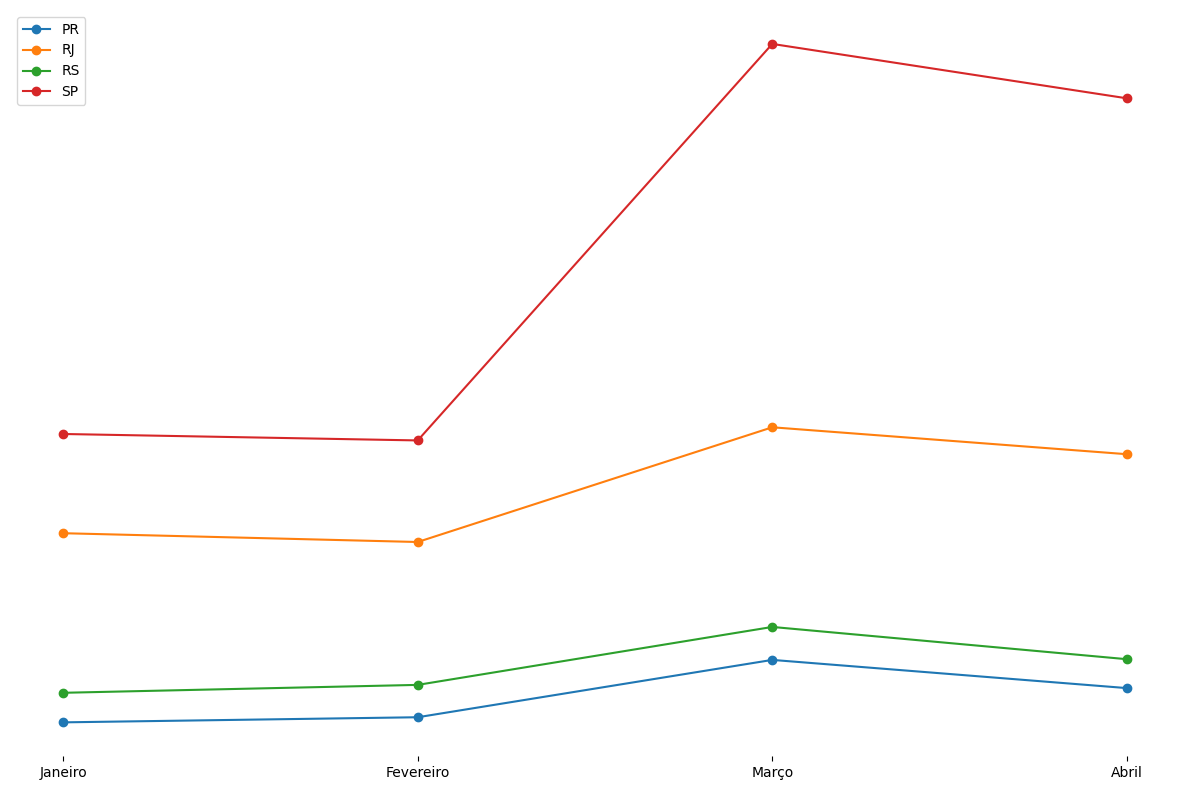

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que sua query já retornou o DataFrame 'resultado'

# Convertendo a coluna 'Mês' para o formato de data
resultado['Mês'] = pd.to_datetime(resultado['Mês'])

# Reorganizando os dados para ter os estados como colunas
df_pivot = resultado.pivot_table(index='Mês', columns='Estado', values='Faturamento')

# Plotando o gráfico
plt.figure(figsize=(12, 8))  # Ajuste o tamanho conforme necessário
for estado in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[estado], marker='o', label=estado)

# Adicionando título e rótulos aos eixos
# Remover a caixa externa do gráfico
plt.box(False)

# Adicionando legenda
plt.legend()

# Definindo os rótulos do eixo x
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril']
plt.xticks(df_soma_mes.index, meses)

# Remover o eixo y
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Rotacionando os rótulos dos meses para facilitar a leitura
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


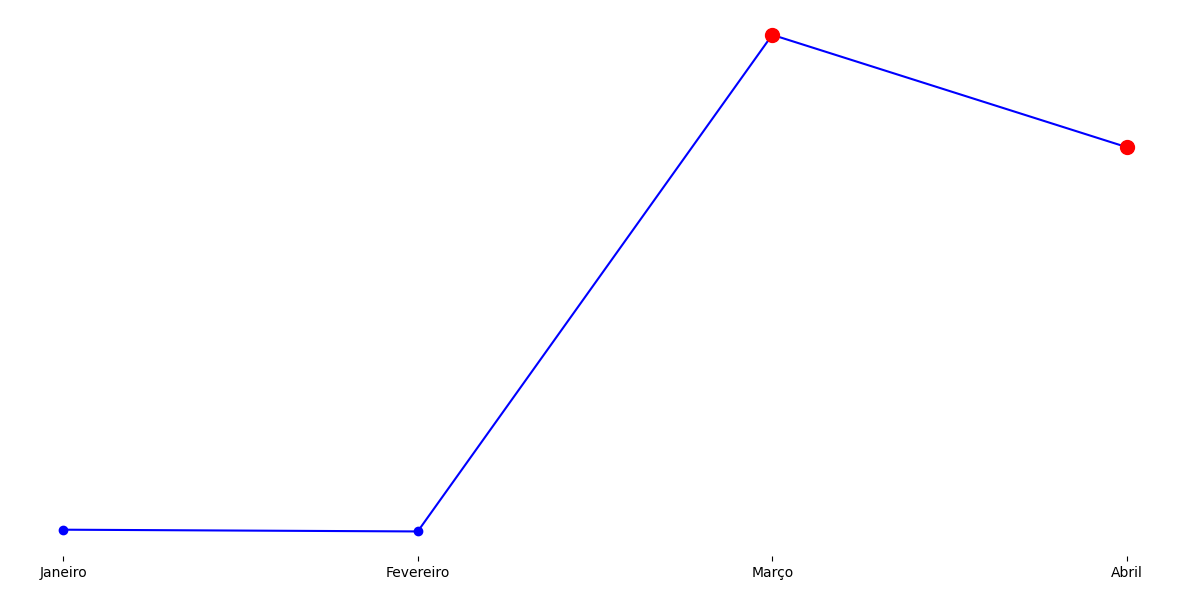

In [ ]:
import matplotlib.pyplot as plt

# Plotando o gráfico
plt.figure(figsize=(12, 6))  # Ajuste o tamanho conforme necessário
plt.plot(df_soma_mes.index, df_soma_mes.values, marker='o', color='blue')  # Plotar todos os meses em azul

# Destacar os últimos dois meses com marcadores vermelhos
plt.plot(df_soma_mes.index[-2:], df_soma_mes.values[-2:], marker='o', markersize=10, color='red', linestyle='None')  

# Remover a caixa externa do gráfico
plt.box(False)

# Remover o eixo y
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Definindo os rótulos do eixo x
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril']
plt.xticks(df_soma_mes.index, meses)

# Rotacionando os rótulos dos meses para facilitar a leitura
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


In [ ]:
query = """
SELECT
    hubs.hub_state,
    orders.order_created_month,
    COUNT(orders.order_id) as quantidade_vendas
FROM 
    hubs
INNER JOIN
    stores
        ON
            hubs.hub_id = stores.hub_id
INNER JOIN
    orders
        ON 
            orders.store_id = stores.store_id
INNER JOIN
    deliveries
        ON
            deliveries.delivery_order_id = orders.order_id
INNER JOIN
    drivers
        ON
            drivers.driver_id = deliveries.driver_id
WHERE
    deliveries.delivery_status = 'DELIVERED' AND
    drivers.driver_modal = 'MOTOBOY' AND
    deliveries.delivery_distance_meters < 24000
GROUP BY
    hubs.hub_state,
    orders.order_created_month
ORDER BY
    quantidade_vendas DESC
"""

resultado = pd.DataFrame(con.execute(query).fetchall(), columns=['Estado','Mês', 'Qtdade_Vendas'])
resultado


,Estado,Mês,Qtdade_Vendas
0,SP,3,41185
1,SP,4,40424
2,RJ,3,24241
3,RJ,4,22529
4,SP,1,22488
5,SP,2,21955
6,RJ,1,19487
7,RJ,2,18621
8,PR,3,9071
9,RS,3,8518


In [ ]:
query = """
SELECT
    hubs.hub_state,
    orders.order_created_month,
    COUNT(orders.order_id) as quantidade_vendas,
    SUM(orders.order_amount) as valor_total_vendas,
    AVG(orders.order_amount) as ticket_medio
FROM 
    hubs
INNER JOIN
    stores
        ON
            hubs.hub_id = stores.hub_id
INNER JOIN
    orders
        ON 
            orders.store_id = stores.store_id
INNER JOIN
    deliveries
        ON
            deliveries.delivery_order_id = orders.order_id
INNER JOIN
    drivers
        ON
            drivers.driver_id = deliveries.driver_id
WHERE
    deliveries.delivery_status = 'DELIVERED' AND
    deliveries.delivery_distance_meters < 24000
GROUP BY
    hubs.hub_state,
    orders.order_created_month
ORDER BY
    hubs.hub_state,
    orders.order_created_month

"""

resultado = round(pd.DataFrame(con.execute(query).fetchall(),
                               columns=['hub_state','order_created_month','quantidade_vendas', 'valor_total_vendas','ticket_medio']),2)
resultado


,hub_state,order_created_month,quantidade_vendas,valor_total_vendas,ticket_medio
0,PR,1,4125,267112.54,64.75
1,PR,2,5070,324597.77,64.02
2,PR,3,11128,825069.48,74.14
3,PR,4,8294,570428.09,68.78
4,RJ,1,32309,2714664.60,84.02
5,RJ,2,30817,2586982.57,83.95
6,RJ,3,39472,3821411.22,96.81
7,RJ,4,35655,3430040.72,96.20
8,RS,1,7389,542536.40,73.42
9,RS,2,7596,598508.82,78.79


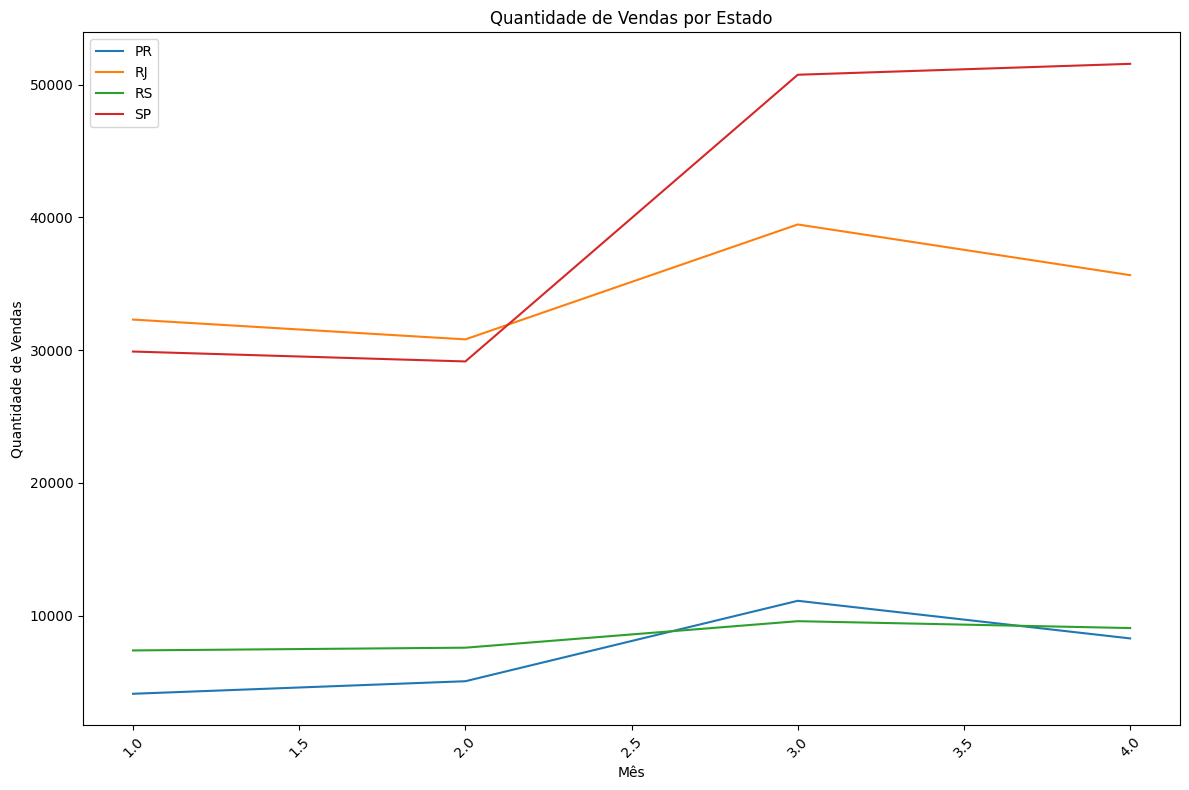

In [ ]:
import matplotlib.pyplot as plt

# Supondo que 'resultado' seja o DataFrame retornado pela sua query

# Crie uma figura e um eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Para cada estado no DataFrame
for estado in resultado['hub_state'].unique():
    # Filtra os dados apenas para o estado atual
    dados_estado = resultado[resultado['hub_state'] == estado]
    
    # Plota os dados do estado atual
    ax.plot(dados_estado['order_created_month'], dados_estado['quantidade_vendas'], label=estado)

# Adiciona um título e rótulos de eixos
ax.set_title('Quantidade de Vendas por Estado')
ax.set_xlabel('Mês')
ax.set_ylabel('Quantidade de Vendas')

# Adiciona uma legenda
ax.legend()

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos dos meses para melhor visualização
plt.tight_layout()
plt.show()


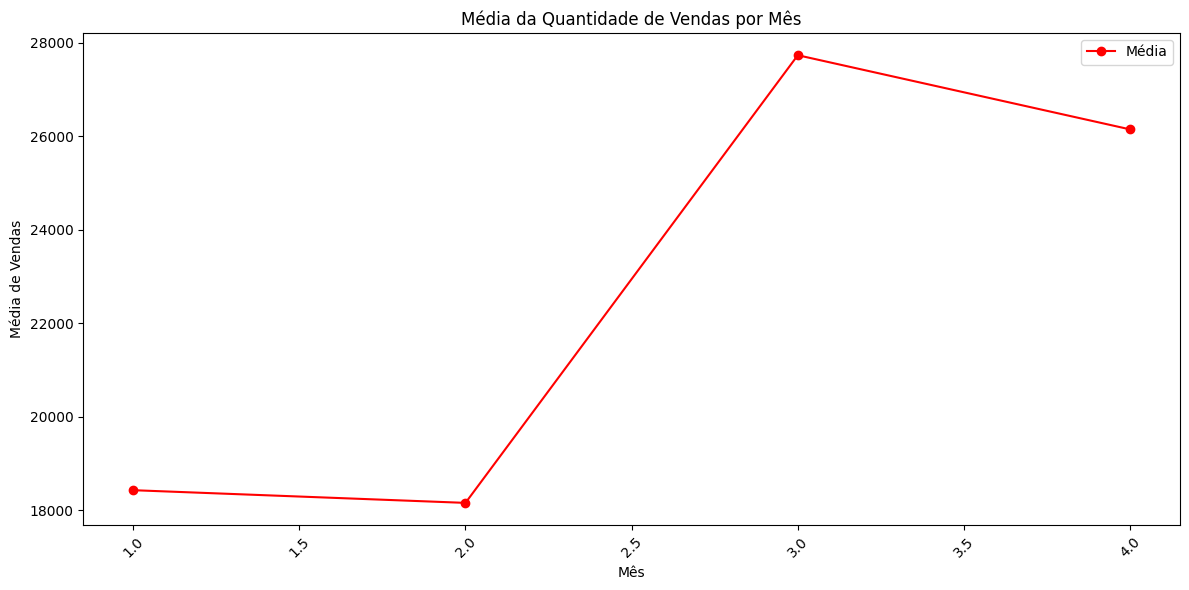

In [ ]:
import matplotlib.pyplot as plt

# Calcula a média da quantidade de vendas por mês em todos os estados
media_vendas = resultado.groupby('order_created_month')['quantidade_vendas'].mean()

# Cria uma figura e um eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plota a média da quantidade de vendas
ax.plot(media_vendas.index, media_vendas.values, marker='o', color='red', label='Média')

# Adiciona um título e rótulos de eixos
ax.set_title('Média da Quantidade de Vendas por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Média de Vendas')

# Adiciona uma legenda
ax.legend()

# Rotaciona os rótulos dos meses para melhor visualização
plt.xticks(rotation=45)

# Mostra o gráfico
plt.tight_layout()
plt.show()


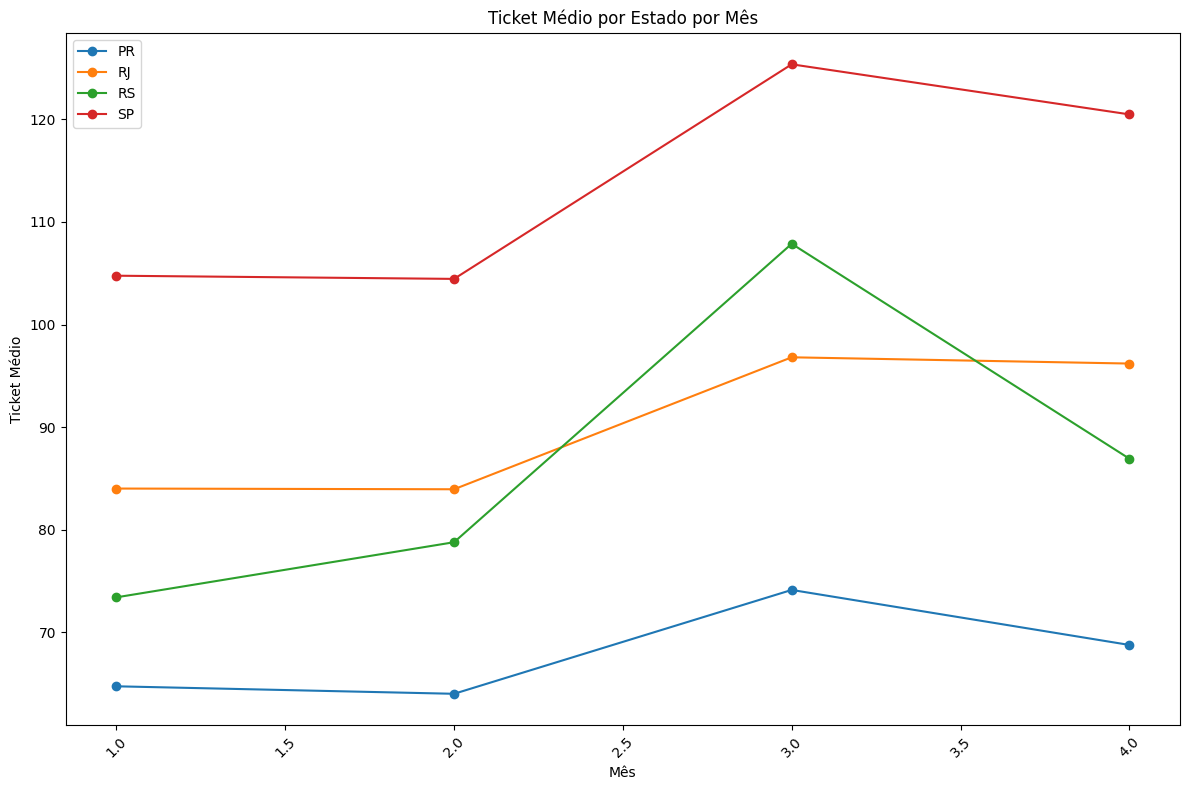

In [ ]:
import matplotlib.pyplot as plt

# Cria uma figura e um eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Para cada estado no DataFrame
for estado in resultado['hub_state'].unique():
    # Filtra os dados apenas para o estado atual
    dados_estado = resultado[resultado['hub_state'] == estado]
    
    # Plota os dados do estado atual
    ax.plot(dados_estado['order_created_month'], dados_estado['ticket_medio'], marker='o', label=estado)

# Adiciona um título e rótulos de eixos
ax.set_title('Ticket Médio por Estado por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Ticket Médio')

# Adiciona uma legenda
ax.legend()

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos dos meses para melhor visualização
plt.tight_layout()
plt.show()


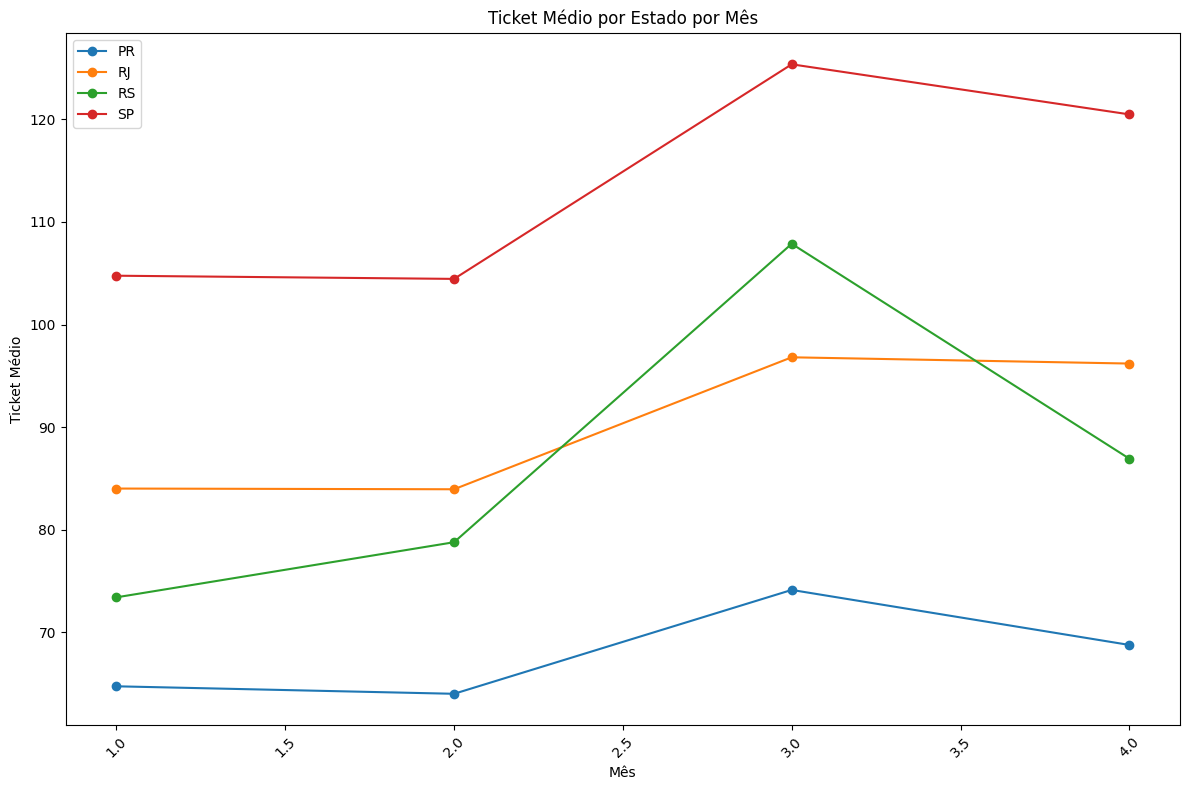

In [ ]:
import matplotlib.pyplot as plt

# Calcula a média dos tickets médios por mês em todos os estados
media_ticket_medio = resultado.groupby('order_created_month')['ticket_medio'].mean()

# Cria uma figura e um eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Para cada estado no DataFrame
for estado in resultado['hub_state'].unique():
    # Filtra os dados apenas para o estado atual
    dados_estado = resultado[resultado['hub_state'] == estado]
    
    # Plota os dados do estado atual
    ax.plot(dados_estado['order_created_month'], dados_estado['ticket_medio'], marker='o', label=estado)



# Adiciona um título e rótulos de eixos
ax.set_title('Ticket Médio por Estado por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Ticket Médio')

# Adiciona uma legenda
ax.legend()

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos dos meses para melhor visualização
plt.tight_layout()
plt.show()


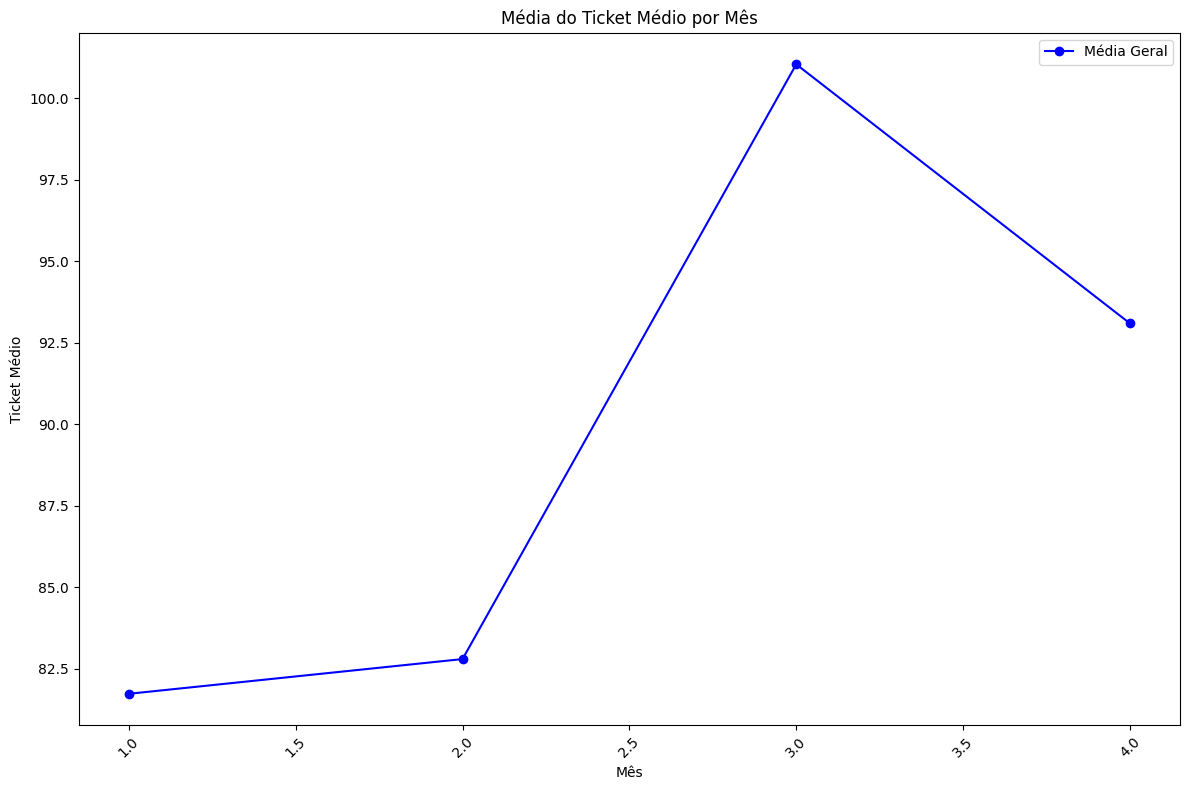

In [ ]:
import matplotlib.pyplot as plt

# Calcula a média dos tickets médios por mês em todos os estados
media_ticket_medio = resultado.groupby('order_created_month')['ticket_medio'].mean()

# Cria uma figura e um eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Plota a média dos tickets médios em todos os estados por mês
ax.plot(media_ticket_medio.index, media_ticket_medio.values, marker='o', color='blue', label='Média Geral')

# Adiciona um título e rótulos de eixos
ax.set_title('Média do Ticket Médio por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Ticket Médio')

# Adiciona uma legenda
ax.legend()

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos dos meses para melhor visualização
plt.tight_layout()
plt.show()
